In [1]:
import torch
import numpy as np
from matplotlib import pyplot as plt
import sys
sys.path.insert(1,"./src")

from multi_ntf import run_single, calculate_loss

#
import torch.nn as nn


import tensorly as tl
from tensorly import unfold as tl_unfold
from tensorly.decomposition import parafac, non_negative_parafac

Using numpy backend.


In [2]:
words = np.load("./data/words_100.npy", allow_pickle=True)
X = np.load("./data/tweets_bag_100.npy", allow_pickle=True)


X = X.reshape((8, 10, -1))

## Some Helper Functions for Visualizaton

In [3]:
def display_text(Factor, n=5, latex=False):
    
    r = Factor.shape[1]
    
    keywords = np.empty((n+2,r), dtype=object)

    for i in range(keywords.shape[1]):
        keywords[0,i] = "Topic " + str(i+1)
        keywords[1,i] = "-------"

    for i in range(Factor.shape[1]):
        col = Factor[:,i]
        top = col.argsort()
        top = top[-n:][::-1]

        keywords[2:,i] = words[top]

    if not latex:
        print("")
        print("RANK", r,  "KEYWORDS:")  
        print("------------------")

        col_widths = [max([len(keywords[i][j]) for i in range(keywords.shape[0])])+2 for j in range(keywords.shape[1])]
        for row in keywords:
            print("".join(row[i].ljust(col_widths[i]) for i in range(len(row))))
    
    else:
        print("")
        print("For LaTeX table...")  
        print("------------------")
        col_widths = [max([len(keywords[i][j]) for i in range(keywords.shape[0])])+2 for j in range(keywords.shape[1])]
        for i, row in enumerate(keywords):
            if(i >= 2):
                print(" & ".join([row[i] for i in range(0,r//2)]) + " \\\\")
        for i, row in enumerate(keywords):
            if(i >= 2):
                print(" & ".join([row[i] for i in range(r//2,r)]) + " \\\\")

        print("")
        print("")


In [4]:
def show_factors(Factor1, Factor2, figsize=(11,4), color = "viridis"):
    
    Factor = Factor1
    r = Factor.shape[1]

    fig, axs = plt.subplots(1, r*2, constrained_layout=True, figsize=figsize)

    vmin = np.min(Factor)
    vmax = np.max(Factor)

    for i in range(r):

        plt.sca(axs[i])
        plt.xticks(range(1), range(i+1,i+2),fontsize=21)
        if(i>0):
            axs[i].axes.yaxis.set_ticks([])
        else:
            plt.yticks(range(8), ['Clinton', 'Kaine', 'O\'Malley', 'Sanders', 'Cruz', 'Kasich', 'Rubio', 'Trump'], fontsize=18)
        axs[i].imshow(Factor[:,[i]], cmap=plt.get_cmap(color), vmin=vmin, vmax=vmax)

        ax = axs[i]
        xleft, xright = ax.get_xlim()
        ybottom, ytop = ax.get_ylim()
        #ax.set_aspect(1)

    Factor = Factor2
    
    vmin = np.min(Factor)
    vmax = np.max(Factor)

    for i in range(r):

        plt.sca(axs[i+r])
        plt.xticks(range(1), range(i+1,i+2),fontsize=21)
        if(i>0):
            axs[i+r].axes.yaxis.set_ticks([])
        else:
            plt.yticks(range(10), ['          Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov'], fontsize=18)
        axs[i+r].imshow(Factor[:,[i]], cmap=plt.get_cmap(color), vmin=vmin, vmax=vmax)

        ratio = 1
        ax = axs[i+r]
        xleft, xright = ax.get_xlim()
        ybottom, ytop = ax.get_ylim()
        #ax.set_aspect(abs((xright-xleft)/(ybottom-ytop))*ratio)
        
    plt.show()

## Run Multi-HNTF Method

In [5]:
r=8
k = len(X.shape)
# Factors_0 = non_negative_parafac(X, rank=r)

results = np.load("./data/results_twitter_ncpd.npy", allow_pickle=True).item()

# Here we load in the initial factor matrices to make sure they are the same accross comparisons
X_1 = results['X_1']
X_2 = results['X_2']
X_3 = results['X_3']
Factors_0 = [X_1, X_2, X_3]

In [6]:
np.random.seed(0)
W = run_single(X, Factors_0, 4, N=800)
Factors_1 = [Factors_0[i] @ W for i in range(k)]

In [7]:
W2 = run_single(X, Factors_1, 2, N=800)
Factors_2 = [Factors_1[i] @ W2 for i in range(k)]

## Measure Relative Reconstruction Loss

In [8]:
print(calculate_loss(X, Factors_0) / np.linalg.norm(X))
print(calculate_loss(X, Factors_1) / np.linalg.norm(X))
print(calculate_loss(X, Factors_2) / np.linalg.norm(X))

0.8325597259468733
0.885979153074565
0.9207360875427409


## Visualize the Topics

In [9]:
display_text(Factors_0[2], 5)
print()
display_text(Factors_1[2], 5)
print()
display_text(Factors_2[2], 5)


RANK 8 KEYWORDS:
------------------
Topic 1          Topic 2     Topic 3     Topic 4  Topic 5     Topic 6        Topic 7        Topic 8    
-------          -------     -------     -------  -------     -------        -------        -------    
martinomalley    marcorubio  johnkasich  crooked  tedcruz     senate         berniesanders  trump      
hillaryclinton   teammarco   kasich      hillary  cruz        florida        people         hillary    
realdonaldtrump  vote        ohio        thank    ted         zika           bernie         donald     
campaigning      flsen       john        great    internet    venezuela      must           president  
maryland         click       gov         clinton  choosecruz  nicolasmaduro  change         timkaine   


RANK 4 KEYWORDS:
------------------
Topic 1     Topic 2          Topic 3     Topic 4        
-------     -------          -------     -------        
johnkasich  crooked          tedcruz     trump          
kasich      hillary       

In [10]:
i = [7,5,0,6,4,2,1,3]
i2 = [3,2,0,1]

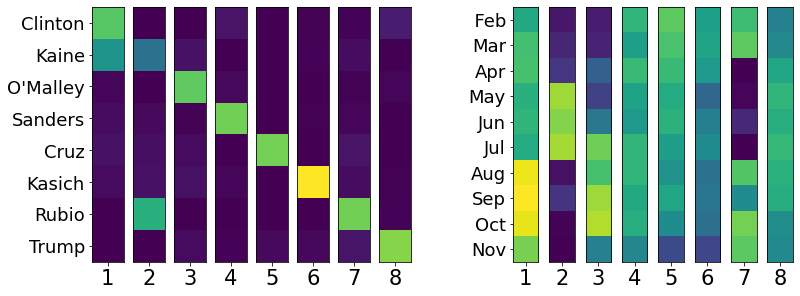

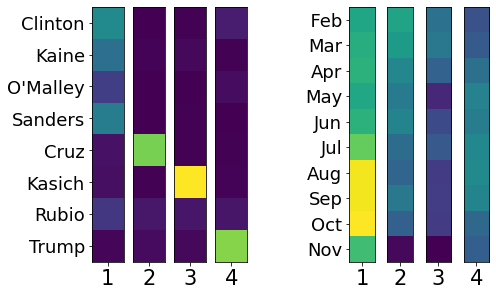

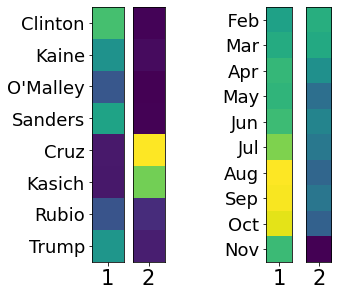

In [11]:
show_factors(Factors_0[0][:,i], Factors_0[1][:,i], figsize=(11,4))
show_factors(Factors_1[0][:,i2], Factors_1[1][:,i2], figsize=(6.8,4))
show_factors(Factors_2[0], Factors_2[1], figsize=(4.6,4))

In [12]:
display_text(Factors_0[2][:,i], 5, latex=True)
display_text(Factors_1[2][:,i2], 5, latex=True)
display_text(Factors_2[2], 5, latex=True)


For LaTeX table...
------------------
trump & senate & martinomalley & berniesanders \\
hillary & florida & hillaryclinton & people \\
donald & zika & realdonaldtrump & bernie \\
president & venezuela & campaigning & must \\
timkaine & nicolasmaduro & maryland & change \\
tedcruz & johnkasich & marcorubio & crooked \\
cruz & kasich & teammarco & hillary \\
ted & ohio & vote & thank \\
internet & john & flsen & great \\
choosecruz & gov & click & clinton \\



For LaTeX table...
------------------
trump & tedcruz \\
hillary & cruz \\
vote & ted \\
people & internet \\
berniesanders & choosecruz \\
johnkasich & crooked \\
kasich & hillary \\
ohio & thank \\
john & great \\
gov & realdonaldtrump \\



For LaTeX table...
------------------
trump \\
hillary \\
people \\
vote \\
realdonaldtrump \\
tedcruz \\
cruz \\
ted \\
johnkasich \\
kasich \\




## Extra: Visualize the W Matrices

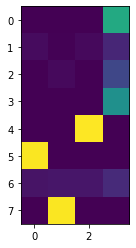

In [13]:
plt.imshow(W[i])

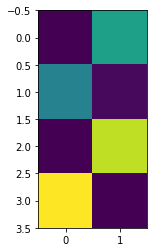

In [14]:
plt.imshow(W2)